# Обучение классификатора с помощью RNN

Установим модуль datasets, чтобы нам проще было работать с данными

In [ ]:
!pip install datasets

Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

In [ ]:
# Загрузим датасет
dataset = datasets.load_dataset('imdb')

In [ ]:
dataset['train']['text'][5000]

'I used to be an avid viewer until I personally spent long cold hours helping build a home for the White Family, only to be sickened to see the house a year later. All of the beautiful rock landscaping has been removed, the gorgeous rock sidewalk and front fountain have been removed, all the pine trees and pecan trees in the front have been cut down, sprinkler system has been ripped out. It now looks like a disaster area. They don\'t even live there any more... they live "in town" and come out only for the weekend. It sickens me to think of all the hours that the great people of Oklahoma donated to these people and to see the result. The story that we all saw on TV wasn\'t completely the truth... don\'t believe every thing you see and hear.'

In [ ]:
words = Counter()
i=0
for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))
    if i==0:
      print(word_tokenize(prccessed_text))
      i+=1
    for word in word_tokenize(prccessed_text):

        words[word] += 1

  0%|          | 0/25000 [00:00<?, ?it/s]

['i', 'rented', 'i', 'am', 'curiousyellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '1967', 'i', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized', 'by', 'us', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', 'therefore', 'being', 'a', 'fan', 'of', 'films', 'considered', 'controversial', 'i', 'really', 'had', 'to', 'see', 'this', 'for', 'myselfbr', 'br', 'the', 'plot', 'is', 'centered', 'around', 'a', 'young', 'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants', 'to', 'learn', 'everything', 'she', 'can', 'about', 'life', 'in', 'particular', 'she', 'wants', 'to', 'focus', 'her', 'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average', 'swede', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'vietnam', 'war', 'and', 'race', 'issues', 'in', 'the', 'united', 'sta

In [ ]:
words

Counter({'i': 75732,
         'rented': 337,
         'am': 2769,
         'curiousyellow': 3,
         'from': 20392,
         'my': 12443,
         'video': 1547,
         'store': 477,
         'because': 8990,
         'of': 145326,
         'all': 23156,
         'the': 334696,
         'controversy': 49,
         'that': 69353,
         'surrounded': 133,
         'it': 77109,
         'when': 14087,
         'was': 48008,
         'first': 8857,
         'released': 944,
         'in': 93028,
         '1967': 46,
         'also': 9073,
         'heard': 1094,
         'at': 23360,
         'seized': 10,
         'by': 22365,
         'us': 3920,
         'customs': 34,
         'if': 16606,
         'ever': 5804,
         'tried': 760,
         'to': 135042,
         'enter': 193,
         'this': 75190,
         'country': 838,
         'therefore': 332,
         'being': 6570,
         'a': 161941,
         'fan': 1848,
         'films': 7727,
         'considered': 482,
     

In [ ]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

In [ ]:
vocab

{'slash',
 'inadvertently',
 'andy',
 'flower',
 'scored',
 'inheritance',
 'are',
 'insights',
 'compensate',
 'plausible',
 'omar',
 'doo',
 'irrelevant',
 'footsteps',
 'murder',
 'intricate',
 'judd',
 'shrill',
 'chop',
 'knows',
 'culture',
 'fez',
 'vic',
 'swift',
 'finding',
 'magazines',
 'conquest',
 'eager',
 'winners',
 'morris',
 'worry',
 'georgia',
 'looney',
 'finish',
 'dreamy',
 'grew',
 'clean',
 'heck',
 'hippies',
 'apple',
 'sam',
 'aztec',
 'casually',
 'served',
 'imaginative',
 'noise',
 'spice',
 'homer',
 'bones',
 'centered',
 'upper',
 'nick',
 'pictures',
 'woefully',
 'lighthearted',
 'fluid',
 'criminally',
 'industry',
 '1950',
 'genuinely',
 'endearing',
 'directorwriter',
 'consequences',
 'screenbr',
 'captivating',
 'exgirlfriend',
 'insanely',
 'altmans',
 'snow',
 'coppola',
 'barn',
 'may',
 'lately',
 'seenbr',
 'whod',
 'nora',
 'crown',
 'picturebr',
 'nauseating',
 'screenplay',
 'guessing',
 'guy',
 'writes',
 'valley',
 'lineup',
 'coleman

In [ ]:
len(vocab)

11399

In [ ]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [ ]:
word2ind['<eos>']

9967

In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [ ]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 2000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 128
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Архитектура модели

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 2,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

## Train loop

In [ ]:
def evaluate(model) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [ ]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/196 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/196 [00:00<?, ?it/s]

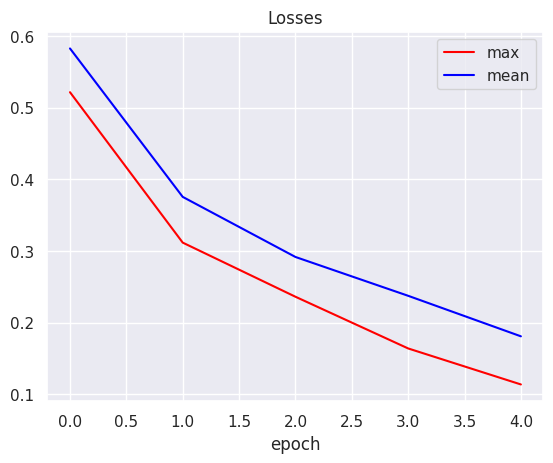

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 86.75
Лучшая accuracy для подхода mean: 86.80


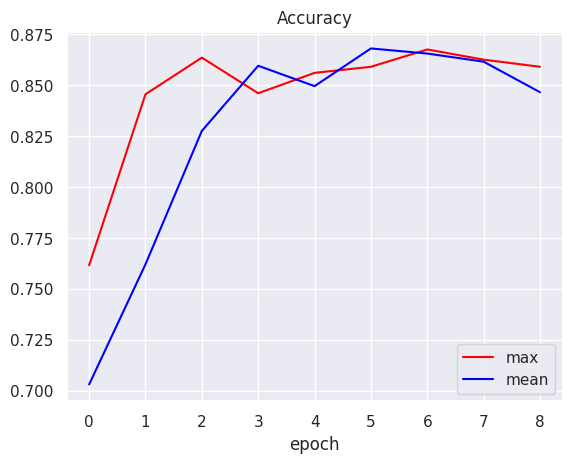

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()